In [91]:
# Importing the required libraries and setting up the device agnostic code
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

!pip install torchmetrics
from torchmetrics import Accuracy

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [92]:
torch.__version__

'2.2.1+cu121'

In [93]:
import matplotlib.pyplot as plt

### 1. Load the torchvision.datasets.MNIST() train and test datasets

In [94]:
train_data = datasets.MNIST(root = 'data',
                            train = True,
                            download = True,
                            transform = ToTensor(),
                            target_transform = None)

test_data = datasets.MNIST(root = 'data',
                            train = False,
                            download = True,
                            transform = ToTensor(),
                            target_transform = None)

In [95]:
print(f'length of train data: {len(train_data)}\nlength of test data: {len(test_data)}')

length of train data: 60000
length of test data: 10000


In [96]:
type(train_data[0][0]), type(train_data[0][1])

(torch.Tensor, int)

In [97]:
train_data[0][0].shape

torch.Size([1, 28, 28])

In [98]:
train_data.classes, train_data.class_to_idx

(['0 - zero',
  '1 - one',
  '2 - two',
  '3 - three',
  '4 - four',
  '5 - five',
  '6 - six',
  '7 - seven',
  '8 - eight',
  '9 - nine'],
 {'0 - zero': 0,
  '1 - one': 1,
  '2 - two': 2,
  '3 - three': 3,
  '4 - four': 4,
  '5 - five': 5,
  '6 - six': 6,
  '7 - seven': 7,
  '8 - eight': 8,
  '9 - nine': 9})

In [99]:
type(train_data.data)

torch.Tensor

(-0.5, 27.5, 27.5, -0.5)

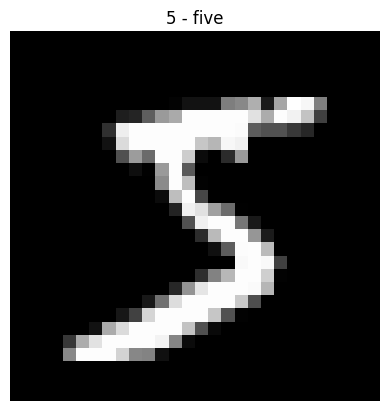

In [101]:
plt.imshow(train_data[0][0].squeeze(), cmap = 'gray')
plt.title(train_data.classes[train_data[0][1]])
plt.axis(False)

In [102]:
train_data, test_data

(Dataset MNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

### 2. Turn the MNIST train and test datasets into dataloaders using `torch.utils.data.DataLoader`, set the batch_size=32.

In [103]:
train_dataloader = DataLoader(dataset = train_data,
                              batch_size = 32,
                              shuffle = True)

test_dataloader = DataLoader(dataset = test_data,
                             batch_size = 32,
                             shuffle = False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x79a3e764bdf0>,
 <torch.utils.data.dataloader.DataLoader at 0x79a3ecea1ff0>)

In [104]:
print(f'length of the train_dataloader (number of batches): {len(train_dataloader)}')
print(f'length of the test_dataloader (number of batches): {len(test_dataloader)}')

length of the train_dataloader (number of batches): 1875
length of the test_dataloader (number of batches): 313


### 3. Recreate `model_2` used in this notebook \(the same model from the CNN Explainer website, also known as TinyVGG\) capable of fitting on the MNIST dataset.

In [105]:
class TinyVGG(nn.Module):
  def __init__(self, in_: int, hide_: int, out_: int):
    super().__init__()
    self.layer_stack_1 = nn.Sequential(
        nn.Conv2d(in_channels = in_,
                  out_channels = hide_,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hide_,
                  out_channels = hide_,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )
    self.layer_stack_2 = nn.Sequential(
        nn.Conv2d(in_channels = hide_,
                  out_channels = hide_,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hide_,
                  out_channels = hide_,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hide_*7*7, out_features = len(train_data.classes))
    )

  def forward(self, x):
    x = self.layer_stack_1(x)
    # print(f'shape after 1st layer: {x.shape}')
    x = self.layer_stack_2(x)
    # print(f'shape after 2nd layer: {x.shape}')
    x = self.classifier(x)
    # print(f'shape after 3rd layer: {x.shape}')
    return x

In [106]:
### testing the model with dummy inputs
model_0 = TinyVGG(in_ = 1, hide_ = 10, out_ = len(train_data.classes))
model_0

TinyVGG(
  (layer_stack_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer_stack_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [107]:
accuracy_fn = Accuracy(task = 'multiclass', num_classes = len(train_data.classes))
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_0.parameters(), lr = 0.1)

In [108]:
dummy_x = torch.randn(size = [1,1,28,28])
model_0.eval()
with torch.inference_mode():
  dummy_y = model_0(dummy_x)
dummy_y.shape

torch.Size([1, 10])

In [109]:
dummy_y[:2]

tensor([[ 0.0222, -0.0895,  0.0566, -0.0424, -0.0248, -0.0191,  0.0432, -0.0026,
          0.0106,  0.0030]])

In [110]:
dummy_y.argmax(dim = 1)

tensor([2])

In [111]:
dummy_y[0]

tensor([ 0.0222, -0.0895,  0.0566, -0.0424, -0.0248, -0.0191,  0.0432, -0.0026,
         0.0106,  0.0030])

In [112]:
dummy_y[:2].max(dim = 0)

torch.return_types.max(
values=tensor([ 0.0222, -0.0895,  0.0566, -0.0424, -0.0248, -0.0191,  0.0432, -0.0026,
         0.0106,  0.0030]),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [113]:
dummy_y.max(dim = 1)

torch.return_types.max(
values=tensor([0.0566]),
indices=tensor([2]))

In [114]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_function,
               accuracy_function,
               optimizer: torch.optim,
               device: torch.device = device):
  model.to(device)

  train_loss, train_accuracy = 0, 0

  model.train()
  for batch, (X, y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)

    # Forward pass
    y_pred_logit = model(X)
    y_pred_prob = y_pred_logit.argmax(dim = 1)

    # calculate loss amd accuracy
    loss = loss_function(y_pred_logit, y)
    train_loss += loss
    train_accuracy = accuracy_function(y_pred_prob, y)

    # optimizer zero grad
    optimizer.zero_grad()

    # loss backward
    loss.backward()

    # optimizer step
    optimizer.step()

  train_loss /= len(data_loader)
  train_accuracy /= len(data_loader)

  print(f'train loss: {train_loss} | train accuracy: {train_accuracy}')

In [115]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_function,
              accuracy_function,
              device: torch.device = device):
  model.to(device)
  test_loss, test_accuracy = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)
      # forward pass
      y_pred_logit = model(X)
      y_pred_prob = y_pred_logit.argmax(dim = 1)

      # calculate loss and accuracy
      test_loss += loss_function(y_pred_logit, y)
      test_accuracy += accuracy_function(y_pred_prob, y)

    test_loss /= len(data_loader)
    test_accuracy /= len(data_loader)
    print(f'test loss: {test_loss} | test accuracy: {test_accuracy}')

In [116]:
from tqdm.auto import tqdm

In [117]:
epochs = 3
for epoch in tqdm(range(epochs)):
  print(f'Epochs: {epoch}-----')
  train_step(device=device,
             model = model_0,data_loader = train_dataloader,
             loss_function = loss_fn,
             optimizer = optimizer,
             accuracy_function = accuracy_fn)
  test_step(model = model_0,
            data_loader = test_dataloader,
            loss_function = loss_fn,
            accuracy_function = accuracy_fn,
            device = device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs: 0-----
train loss: 0.28091174364089966 | train accuracy: 0.0005333333392627537
test loss: 0.07749360799789429 | test accuracy: 0.976138174533844
Epochs: 1-----
train loss: 0.07628069072961807 | train accuracy: 0.0005333333392627537
test loss: 0.05683707445859909 | test accuracy: 0.9815295338630676
Epochs: 2-----
train loss: 0.06078501418232918 | train accuracy: 0.0005000000237487257
test loss: 0.0469302199780941 | test accuracy: 0.9840255379676819
